# Correlation between fuel prices and newly registered vehicles in Denmark

## Motivation:
In this project we want to examine whether or not the fuel prices of diesel and gas has any effect on the amount of newly registered vehicles in Denmark. This project is inspired by the current situation with the conflict in Ukraine, which has led to sanctions against Russia. Including sanctions on the russian gas export. This has caused the fuel prices to skyrocket. We want to examine if this will impact the amount of newly registered vehicles in Denmark.

## Data
To examine the aformentioned effect we need to import data from Danmarks Statistik. This is high quality data which is updated every month or so. To make sure our data is correct and up to date, we need to implement an API which scrapes the dataset: PRIS111 and BIL5.

**Description of PRIS111**: PRIS111 is the index prices of diesel and gas, where 2015 is set as benchmark, hence the index is 100 in 2015. This dataset provides the monthly development of prices throughout the timeperiod.

**Description of BIL5**: BIL5 is the amount of vehicles registered monthly devided by vehicle type. We narrow the dataset down to include passenger cars, busses, motorcycles, vans and lorries and vehicles in total. This makes it possible to analyse whether or not fuel prices has any effect on the amount of vehicles registered. 

# Imports

In [1]:
# Importing packages for later use
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')
import ipywidgets as widgets
import seaborn as sns

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# Overview of data from DST

In [2]:
# Overview of subjects in dataset
dst.get_subjects()

,id,desc,active,hasSubjects
0,1,People,True,True
1,2,Labour and income,True,True
2,3,Economy,True,True
3,4,Social conditions,True,True
4,5,Education and research,True,True
5,6,Business,True,True
6,7,Transport,True,True
7,8,Culture and leisure,True,True
8,9,Environment and energy,True,True
9,19,Other,True,True


In [3]:
# Opening subset id 3, Economy
tables = dst.get_tables(subjects=['3'])
print(type(tables))
display(tables)

<class 'pandas.core.frame.DataFrame'>


,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
0,NAN1,Demand and supply,-,2022-03-31 08:00:00,1966,2021,True,"[transaction, price unit, time]"
1,VNAN1,Versionstable NAN1 - Demand and supply (year),-,2022-03-31 08:00:00,1966,2021,True,"[version, transaction, price unit, time]"
2,NAN2,Real gross national disposable income etc.,m DKK,2022-03-31 08:00:00,1966,2021,True,"[transaction, price unit, time]"
3,NAN3,"Consumption, disposable income and saving for ...",-,2022-03-31 08:00:00,1995,2021,True,"[transaction, price unit, time]"
4,NKN1,Demand and supply,-,2022-03-31 08:00:00,1990Q1,2021Q4,True,"[transaction, price unit, seasonal adjustment,..."
...,...,...,...,...,...,...,...,...
360,DNBSTP,Transactions using Danish issued cards,-,2022-05-02 08:00:00,2016Q1,2022Q1,True,"[type, cardholder, data type, time]"
361,DNBSKK,ATMs and card terminals,Number,2022-05-02 08:00:00,2016Q1,2022Q1,True,"[devices, time]"
362,DNBSHI,Withdrawals and deposits,-,2022-05-02 08:00:00,2016Q1,2022Q1,True,"[withdrawels and deposits, point of operation,..."
363,DNBSVKO,Credit transfers in currency,Number,2022-05-02 08:00:00,2016Q1,2022Q1,True,"[type, direction, geographical coverage, data ..."


In [4]:
# Opening table 'PRIS111' - Consumer Price Index
tables[tables.id == 'PRIS111']

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
275,PRIS111,Consumer price index,-,2022-05-10 08:00:00,2001M01,2022M04,True,"[commodity group, unit, time]"


In [5]:
# Defining the Consumer Price Index table as FPI
FPI = dst.get_variables(table_id='PRIS111')
FPI

,id,text,elimination,time,values
0,VAREGR,commodity group,True,False,"[{'id': '000000', 'text': '00 Consumer price i..."
1,ENHED,unit,False,False,"[{'id': '100', 'text': 'Index'}, {'id': '200',..."
2,Tid,time,False,True,"[{'id': '2001M01', 'text': '2001M01'}, {'id': ..."


In [6]:
# Illustrating the FPI table by id and text
FPI_show = dst.get_variables(table_id='PRIS111')

In [7]:
# Opening subset id 7, Transport
tables = dst.get_tables(subjects=['7'])
tables

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
0,BIL5,New registration of motor vehicles,Number,2022-05-10 08:00:00,1992M01,2022M04,True,"[type of vehicle, time]"
1,BIL55,New registrated passenger cars,Number,2022-05-10 08:00:00,2007M01,2022M04,True,"[type of registration, time]"
2,BIL6,"New registrations, sale of second hand vehicle...",Number,2022-05-10 08:00:00,2000M01,2022M04,True,"[type of vehicle, unit, time]"
3,BIL50,New registration of passenger cars,-,2022-05-10 08:00:00,2004M01,2022M04,True,"[ownership, car segment, unit, time]"
4,BIL51,New registrations of passenger cars,Number,2022-05-10 08:00:00,2011M01,2022M04,True,"[ownership, propellant, time]"
...,...,...,...,...,...,...,...,...
162,MOERKE1,Injured in road traffic accidents reported by ...,Number,2021-04-16 08:00:00,2009,2018,True,"[reporter, accident situation, means of transp..."
163,BANE91,Fatalities and injuries in railway traffic acc...,Number,2021-08-31 08:00:00,1993,2020,True,"[railway system, category of person, casualty,..."
164,BANE92,Fatalities and injuries in railway traffic acc...,Number,2021-08-31 08:00:00,2002,2020,True,"[railway system, type of accident, casualty, t..."
165,SKIB95,Accidents at sea involving danish vessels,Number,2022-05-12 08:00:00,2014,2021,True,"[type of accident, type of vessel, scope, time]"


In [8]:
# Opening table 'BIL5' - Newly registered vehicles
tables[tables.id == 'BIL5']

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
0,BIL5,New registration of motor vehicles,Number,2022-05-10 08:00:00,1992M01,2022M04,True,"[type of vehicle, time]"


In [9]:
# Defining the Consumer Price Index table as FPI
CAR_show = dst.get_variables(table_id='BIL5')
CAR_show

,id,text,elimination,time,values
0,BILTYPE,type of vehicle,True,False,"[{'id': '4000100001', 'text': 'Vehicles total'..."
1,Tid,time,False,True,"[{'id': '1992M01', 'text': '1992M01'}, {'id': ..."


In [10]:
# Illustrating the CAR table by id and text
CAR_show = dst.get_variables(table_id='BIL5')

## Referencing tabels from DST

In [11]:
variables_Fuel = {'VAREGR':['072210','072220'],'ENHED':['100'],'TID':['*']}
FPI = dst.get_data(table_id = 'PRIS111', variables=variables_Fuel)
variables_CAR = {'BILTYPE':['4000100001','4000101002', '4000104001','4000102001','4000106001'],'TID':['*']}
CAR = dst.get_data(table_id = 'BIL5', variables=variables_CAR)
FPI.sort_values(by=['VAREGR', 'ENHED', 'TID'], inplace=True)
CAR.sort_values(by=['BILTYPE', 'TID'], inplace=True)

In [12]:
#Cleaning of CAR dataset
CAR_TEMP=CAR.TID.str.split("M", expand=True)
CAR = pd.concat([CAR,CAR_TEMP], axis=1)
CAR.drop(['TID'], axis=1, inplace=True)

In [13]:
#Adding a date variable so that the date variables are compatible
CAR[2]='01'

In [14]:
#Making the date variable and converting to datetime
CAR[3]=CAR[0]+"-"+CAR[1]+"-"+CAR[2]
CAR_TEMP=pd.to_datetime(CAR[3], infer_datetime_format = True)

In [15]:
CAR_TEMP = pd.concat([CAR,CAR_TEMP], axis=1)
CAR.drop([0, 1, 2], axis=1, inplace=True)

In [16]:
CAR

,BILTYPE,INDHOLD,3
871,"Buses, total",58,1992-01-01
811,"Buses, total",67,1992-02-01
876,"Buses, total",180,1992-03-01
946,"Buses, total",115,1992-04-01
881,"Buses, total",164,1992-05-01
...,...,...,...
65,Vehicles total,21865,2021-12-01
165,Vehicles total,12777,2022-01-01
30,Vehicles total,14086,2022-02-01
170,Vehicles total,20013,2022-03-01


In [17]:
FPI_TEMP=FPI.TID.str.split("M", expand=True)
FPI_NY = pd.concat([FPI,FPI_TEMP], axis=1)
FPI_NY.drop([0], axis=1, inplace=True)

In [18]:
#Cleaning the FPI dataset
FPI_TEMP=FPI.TID.str.split("M", expand=True)
FPI = pd.concat([FPI,FPI_TEMP], axis=1)
FPI.drop(['TID'], axis=1, inplace=True)

In [19]:
#Adding date variable to mimic date structure in CAR-dataset.
FPI[2]='01'

In [20]:
#Formatting data
FPI[3]=FPI[0]+"-"+FPI[1]+"-"+FPI[2]
FPI_TEMP=pd.to_datetime(FPI[3], infer_datetime_format = True)

In [21]:
FPI_TEMP = pd.concat([FPI,FPI_TEMP], axis=1)
FPI.drop([0, 1, 2], axis=1, inplace=True)

In [22]:
FPI

,VAREGR,ENHED,INDHOLD,3
262,07.2.2.1 Diesel,Index,..,2001-01-01
194,07.2.2.1 Diesel,Index,..,2001-02-01
258,07.2.2.1 Diesel,Index,..,2001-03-01
330,07.2.2.1 Diesel,Index,..,2001-04-01
390,07.2.2.1 Diesel,Index,..,2001-05-01
...,...,...,...,...
387,07.2.2.2 Petrol,Index,115.8,2021-12-01
323,07.2.2.2 Petrol,Index,119.6,2022-01-01
1,07.2.2.2 Petrol,Index,125.6,2022-02-01
389,07.2.2.2 Petrol,Index,137.5,2022-03-01


In [23]:
# Merging FPI and CAR with inner-merging
FULL = pd.merge(CAR, FPI, on=[3], how='inner')
FULL.sort_values([3], inplace=True)
FULL = FULL.reset_index()

In [24]:
FULL.replace(".." , np.nan, inplace=True)
FULL.rename(columns={"BILTYPE": "Vehicle Type", "INDHOLD_x": "Value", 3: "Date", "VAREGR": "Fuel", 
                     "INDHOLD_y": "Price Index"}, inplace=True)
FULL.drop(['ENHED'], axis=1, inplace=True)

In [25]:
#Transforming cell values to desired values
FULL['Fuel'] = FULL['Fuel'].map(lambda x: x.lstrip('0127. '))

In [26]:
FULL[['Vehicle Type', 'Remove This']] = FULL['Vehicle Type'].str.split(",", expand=True)
FULL.drop(['Remove This'], axis=1, inplace=True)

In [27]:
FULL

,index,Vehicle Type,Value,Date,Fuel,Price Index
0,0,Buses,72,2001-01-01,Diesel,NaN
1,1,Buses,72,2001-01-01,Petrol,NaN
2,2,Motorcycles,34,2001-01-01,Diesel,NaN
3,3,Motorcycles,34,2001-01-01,Petrol,NaN
4,4,Passenger cars,6227,2001-01-01,Diesel,NaN
...,...,...,...,...,...,...
2555,2554,Passenger cars,11152,2022-04-01,Diesel,155.2
2556,2555,Passenger cars,11152,2022-04-01,Petrol,135.8
2557,2556,Vans and lorries,2574,2022-04-01,Diesel,155.2
2558,2557,Vans and lorries,2574,2022-04-01,Petrol,135.8


In [28]:
#Changing datatype to secure nessesary abilities.
FULL['Date'] = pd.to_datetime(FULL['Date'], format='%Y-%m-%d')
FULL['Price Index'] = FULL['Price Index'].astype(float)

In [29]:
FULL['Date'].dt.year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int64)

In [30]:
#Checking whether our variables has the right datatype
result = FULL.dtypes

print("Output:")
print(result)

Output:
index                    int64
Vehicle Type            object
Value                    int64
Date            datetime64[ns]
Fuel                    object
Price Index            float64
dtype: object


# Descriptive Statistic

Now the dataset is both loaded and cleaned and ready to be used for descriptive analysis. This will be presented in the forthcoming section.

Firstly we will provide a histogram of the amount of newly registered vehicles defined by the vehicle type 

In [31]:
#Descriptive statistics on vehicle type
FULL.groupby('Vehicle Type')["Value"].describe()

,count,mean,std,min,25%,50%,75%,max
Vehicle Type,,,,,,,,
Buses,512.0,63.843750,32.026148,4.0,41.75,57.0,80.00,230.0
Motorcycles,512.0,306.292969,296.158385,9.0,81.00,216.5,445.00,1700.0
Passenger cars,512.0,13846.664062,3981.290604,6227.0,10659.25,13924.0,16572.75,26188.0
Vans and lorries,512.0,3204.214844,1178.010820,1154.0,2420.25,3071.0,3635.50,7974.0
Vehicles total,512.0,18645.421875,4484.528173,9666.0,15209.00,18840.0,21693.00,31448.0


**Summary Statistic**

The summary statistic shows that there are 510 observation for each vehicle type. The most bought vehicle type are the passenger cars, whereas the least bought are buses.
The mean of newly registered vehicles each month is presented aswell as the minimum and maximum values. Furthermore the 25% and 75% percentile is presented aswell.

Text(0.5, 1.0, 'Histograms')

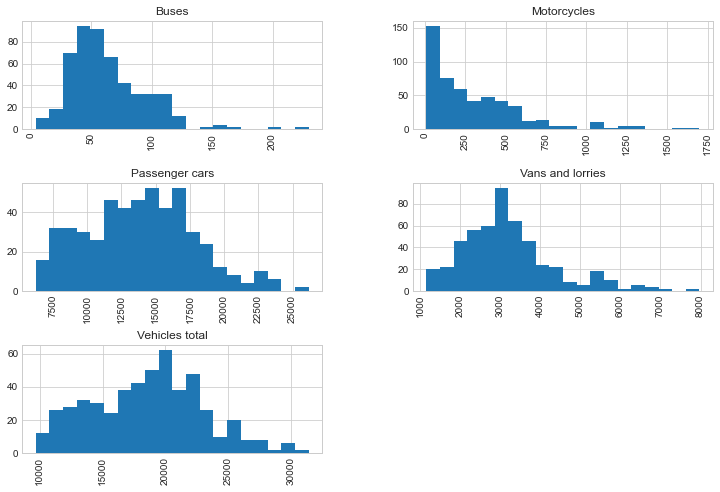

In [32]:
#Plotting histograms on the different vehicle types, by how many vehicles are registered daily 
FULL['Value'].hist(by=FULL['Vehicle Type'], grid=False, bins=20, figsize=(12,8))
plt.title("Histograms")

**Histograms**

The histograms supplies a visual representation of the summary statistics. Busses and motor cycles are scewed a alot towards the left, meaning that most months these vehicle types aren't bought much. Vans and lorries and passenger cars follow a more normal distribution. Due to these groups being the biggest, the histogram for all vehicle types take roughly the same shape.

# Plotting the price index

The indicies are now plotted, where the year 2015 is 100.

<AxesSubplot:title={'center':'Development in Diesel and Petrol prices, 2015=100'}, xlabel='Year', ylabel='Index'>

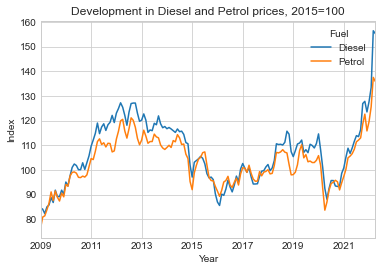

In [33]:
FULL.dropna().groupby(["Date",'Fuel'])["Price Index"].mean().unstack().plot(legend=True, xlabel='Year', ylabel='Index', title = "Development in Diesel and Petrol prices, 2015=100") 

**Price Index**

From the price index plot of Diesel and Petrol we see that the prices are generally increasing with some drops along the way. Furthermore the plot illustrates that the general prices of Diesel is greater than the price of Petrol.

# Interactive plot

This plot shows the correlation between prices on fuel and how many vehicles are registered monthly

In [34]:
#Defining the function to create the scatterplot
def plot(df,Fuel_Type,Vehicle):
    df_temp = df.loc[(df.Fuel==Fuel_Type)&(df["Vehicle Type"]==Vehicle)]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot(x="Price Index",y=df_temp.Value, data=df_temp, ax=ax).set(title='Correlation between price index and vehicles registered')

In [35]:
widgets.interact(plot,
                 df = widgets.fixed(FULL),
                 Vehicle = widgets.Dropdown(
    options = FULL["Vehicle Type"].unique(),
    value = "Buses"),
                Fuel_Type =widgets.Dropdown(
    options = FULL["Fuel"].unique(),
    value = "Diesel"))

interactive(children=(Dropdown(description='Fuel_Type', options=('Diesel', 'Petrol'), value='Diesel'), Dropdow…

<function __main__.plot(df, Fuel_Type, Vehicle)>

**Scatter plot**: By selecting the fuel type and the vehicle type the scatterplot shows the correlation between index prices (marked on the x-axis) and the amount of vehicles registered (marked on the y-axis).

By analyzing the scatterplot the correlations can be examined. For busses and motorcycles the trend is that if fuel prices are higher less vehicles gets registered hence yielding a negative correlation. This is the case for both diesel and gas prices. This is to be expected as the fuel prices are highly correlated.

However the correlation between fuel prices and passenger cars and vans and lorries seem to be almost completely horizontal thus the interpretation seems to be that the fuel prices does not have an impact on the amount of these vehicle types registered.

# Conclusion

We cannot make a final conclusion that there is a negative relation between fuel pricing and the amount of vehicles registered in general, which is what intuitivly makes sense. However there seem to be a negative correlation between fuel prices and the amount of motorcycles asweel as vans and lorries registered.

This could be due to the vehicle demand being relativly inelastic towards the fuel pricing.